In [1]:
import sys
import numpy as np
import pandas as pd
import math
from math import sin, cos, radians
import random

import os
import matplotlib.pyplot as plt
import datetime

import scipy.stats as st
import scipy.signal as sgl
pd.set_option('display.max_columns', 300)

#import fastdtw
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

import scipy.interpolate as spi

#hide warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# remove_duplicated_point
def remove_duplicated_point(df):
    df_new = df.drop(index=df.index)    
    old_x = df['X'][0]
    old_y = df['Y'][0]
    for index, row in df.iterrows():
        if row['X'] != old_x or row['Y']!=old_y or index == 0:
            df_new.loc[len(df_new)] = {'X': row['X'], 'Y': row['Y'], 'TStamp': row['TStamp'], 'Pres': row['Pres'], 'EndPts': row['EndPts'],
                                       'TStamp2': row['TStamp2']}
            old_x = row['X']
            old_y = row['Y']
        # update the EndPts if the point is   
        elif row['X'] == old_x and row['Y'] == old_y and row['EndPts'] == 1:
            df_new.iloc[len(df_new)-1]['EndPts']  = 1
    return df_new

In [3]:
"""
    add new features to signals
"""

def addSigFeature(df):
    dX = derivation(df['X'].tolist())     # dx
    dY = derivation(df['Y'].tolist())     # dy
#     df['dX'] = dX
#     df['dY'] = dY
    Vel = np.zeros(len(df)).tolist()   # velocity
    Angle = np.zeros(len(df)) # angle
    
    
    T = len(df) -1
    t = 1
    while t<= T:
        Vel[t] = math.sqrt(dX[t] * dX[t] + dY[t] * dY[t])
        if dY[t] != 0 and dX[t] != 0:
            Angle[t] = math.atan(dY[t] / dX[t])
        elif dX[t] == 0:
            Angle[t] = math.atan(dY[t] / 0.01)
        else:
            Angle[t] = 0
        t += 1    
    dAngle = derivation(Angle)
    dVel = derivation(Vel)
    Logcr = np.zeros(len(df)).tolist() 
    Tam = np.zeros(len(df)).tolist() #加速度 Acceleration
    
    t = 1
    while t<= T:
        Logcr[t] = math.log((abs(Vel[t]) + 0.01) / ((abs(dAngle[t]) + 0.01))) ;
        Tam[t] = math.sqrt(dVel[t] * dVel[t] + Vel[t] * Vel[t] * dAngle[t] * dAngle[t]) ;
        t += 1
    df['Angle'] = Angle
    df['Vel'] = Vel
    df['Logcr'] = Logcr
    df['Tam'] = Tam
    
    return df
    
    
# calculate the difference of the discrete sequence    
def derivation(signal):
    T = len(signal)-1
    dsignal = np.zeros(len(signal)).tolist()
    dsignal[0] = (2*signal[2] + signal[1] - 3*signal[0]) / 5
    dsignal[1] = (2*signal[3] + signal[2] - 2*signal[1] - signal[0]) / 6
    t= 2
    while t<=T-2:
        dsignal[t] = (2*signal[t+2] + signal[t+1] - signal[t-1] - 2*signal[t-2]) / 10 
#         print(dsignal[t])        
        t += 1
        # (2(Xn+2)+(Xn+1)-(Xn-1)-2(Xn-2))/10 == [2(Xn+2)-2(Xn+1)+3(Xn+1)-3(Xn)+3(Xn)-3(Xn-1)+2(Xn-1)-2(Xn-2)]/10
        
    dsignal[T-1] = (signal[T] - signal[T-2] + 2*signal[T-1] - 2*signal[T-3]) / 6 
    dsignal[T] = (3*signal[T] - signal[T-1] - 2*signal[T-2]) / 5 
    return dsignal

# calculate the first order derivation for all 6 features   
def addFirstOrderDerivation(df):
    d_X = derivation(df['X'].tolist())     
    d_Y = derivation(df['Y'].tolist())     
    d_Angle = derivation(df['Angle'].tolist())   
    d_Vel = derivation(df['Vel'].tolist())   
    d_Logcr = derivation(df['Logcr'].tolist())   
    d_Tam = derivation(df['Tam'].tolist())   
    
    df['d_X'] = d_X
    df['d_Y'] = d_Y
    df['d_Angle'] = d_Angle
    df['d_Vel'] = d_Vel 
    df['d_Logcr'] = d_Logcr 
    df['d_Tam'] = d_Tam 
    
    df['d2_X'] = derivation(d_X) #x轴速度变化率 x-axis speed change
    df['d2_Y'] = derivation(d_Y) #y轴速度变化率 y-axis speed change
    return df

In [4]:
# Size normalization 大小规整
# position normalization 位置规整
def normalizeFile(normalInputFile):
    widthX = 500 #width
    heightY = 200 #height
    minX = normalInputFile['X'].min()
    minY = normalInputFile['Y'].min()
    maxX = normalInputFile['X'].max()
    maxY = normalInputFile['Y'].max()
    normalInputFile['normalX'] = widthX * ((normalInputFile['X'] - minX)/(maxX - minX))
    normalInputFile['normalY'] = heightY * ((normalInputFile['Y'] - minY)/(maxY - minY))
    
    #position normalization
    averX = normalInputFile['normalX'].mean()
    averY = normalInputFile['normalY'].mean()

    normalInputFile['normalX'] = normalInputFile['normalX'] - averX
    normalInputFile['normalY'] = normalInputFile['normalY'] - averY
    
    return normalInputFile


#长度归一化 length normalization
def samelen(data,length=400):   
    data_size = len(data)
    interval = (data_size-1)/length
    start = 0
    new_data = data.drop(index=data.index)
    for dist in np.arange(start, data_size-1, interval):
        first = math.floor(dist)
        second = math.ceil(dist)
        if second >= data_size:
            second = data_size -1
        percent = (dist - first) / 1.0   
        #'X','Y','TStamp','Pres','EndPts'
#         print ((data.X[first] + data.X[second])/2)

#         X = (data.at[first,'X'] + data.at[second,'X']) / 2
#         Y = (data.Y[first] + data.Y[second])/2 
        TStamp = (data.TStamp[first] + data.TStamp[second])/2 
#         normalX = (data.normalX[first] + data.normalX[second])/2
#         normalY = (data.normalY[first] + data.normalY[second])/2 
#         TStamp2 = (data.TStamp2[first] + data.TStamp2[second])/2
        
        X = data.at[first,'X'] + (data.at[second,'X'] - data.at[first,'X']) * percent
        Y = data.at[first,'Y'] + (data.at[second,'Y'] - data.at[first,'Y']) * percent
        normalX = data.at[first,'normalX'] + (data.at[second,'normalX'] - data.at[first,'normalX']) * percent
        normalY = data.at[first,'normalY'] + (data.at[second,'normalY'] - data.at[first,'normalY']) * percent 
        TStamp2 = data.at[first,'TStamp2'] + (data.at[second,'TStamp2'] - data.at[first,'TStamp2']) * percent 
        Pres = data.at[first,'Pres'] + (data.at[second,'Pres'] - data.at[first,'Pres']) * percent 
        Angle = data.at[first,'Angle'] + (data.at[second,'Angle'] - data.at[first,'Angle']) * percent
        Vel = data.at[first,'Vel'] + (data.at[second,'Vel'] - data.at[first,'Vel']) * percent 
        Logcr = data.at[first,'Logcr'] + (data.at[second,'Logcr'] - data.at[first,'Logcr']) * percent 
        Tam = data.at[first,'Tam'] + (data.at[second,'Tam'] - data.at[first,'Tam']) * percent 
        
        d_X = data.at[first,'d_X'] + (data.at[second,'d_X'] - data.at[first,'d_X']) * percent
        d_Y = data.at[first,'d_Y'] + (data.at[second,'d_Y'] - data.at[first,'d_Y']) * percent 
        d_Angle = data.at[first,'d_Angle'] + (data.at[second,'d_Angle'] - data.at[first,'d_Angle']) * percent
        d_Vel = data.at[first,'d_Vel'] + (data.at[second,'d_Vel'] - data.at[first,'d_Vel']) * percent 
        d_Logcr = data.at[first,'d_Logcr'] + (data.at[second,'d_Logcr'] - data.at[first,'d_Logcr']) * percent 
        d_Tam = data.at[first,'d_Tam'] + (data.at[second,'d_Tam'] - data.at[first,'d_Tam']) * percent 
        
        if data.EndPts[first] == 1 or data.EndPts[second] == 1:
            EndPts = 1
        else:
            EndPts = 0
            
        new_data.loc[len(new_data)] = {'X': X, 'Y': Y, 'TStamp': TStamp, 'Pres': Pres, 'EndPts': EndPts,'normalX': normalX,
                         'normalY': normalY, 'TStamp2': TStamp2,'Angle': Angle,'Vel': Vel,'Logcr': Logcr,'Tam': Tam,
                         'd_X': d_X, 'd_Y': d_Y,'d_Angle': d_Angle,'d_Vel': d_Vel,'d_Logcr': d_Logcr,'d_Tam': d_Tam,} 
    return new_data

In [5]:
"""
    calculate the euclidean distance using DTW of two sequences 
"""
def calDistance():
    #set ts_a
    normalX = np.array(data1['normalX'])
    normalY = np.array(data1['normalY'])
    list(zip(normalX,normalY))
    ts_a = np.array(list(zip(normalX,normalY)),dtype=float)
#     print(normalX)

    #set ts_b
    normalX = np.array(data2['normalX'])
    normalY = np.array(data2['normalY'])
    list(zip(normalX,normalY))
    ts_b = np.array(list(zip(normalX,normalY)),dtype=float)

    #set ts_c
    normalX = np.array(data3['normalX'])
    normalY = np.array(data3['normalY'])
    list(zip(normalX,normalY))
    ts_c = np.array(list(zip(normalX,normalY)),dtype=float)


    #the plot of DTW distance for genuine signature
    distance, path = fastdtw(ts_a, ts_b, dist=euclidean)
    print("genuine signature distance: ", distance)    

In [6]:
"""
    计算手写图形的点速度快速变化的点的数目
    Count the number of points with rapid speed changes 
"""
def cal_vel_change_num(df):
    inter_points = []
    angle_points_x = []
    angle_points_y = []
    X = df['X']
    Y = df['Y']
    Angle = df['Angle']
    d_X = df['d_X']
    d_Y = df['d_Y']
    
    i=5
    while i< len(df)-4:
        j = i + 1
        x1 = X[i]
        y1 = Y[i]
        angle1 = Angle[i]
        d_x1 = d_X[i]
        d_y1 = d_Y[i]
#         while j < len(df)-1:
        x2 = X[j]
        y2 = Y[j]
        d_x2 = d_X[j]
        d_y2 = d_Y[j]        
        angle2 = Angle[j]
        if math.sqrt(np.square(d_x1 - d_x2) + np.square(d_y1 - d_y2)) > 60: 
#         if abs(angle2 - angle1) > 1: 
            angle_points_x.append(x1)
            angle_points_y.append(y1)
#             print(x1,y1,i,angle1,x2,y2,j,angle2)
            i += 4
#             break
#             j += 1
        i += 1
#     print(angle_points_x, angle_points_y)
    return len(angle_points_x)
#     return angle_points_x, angle_points_y
    
# temp = 'dataset/SUSIG/GENUINE/SESSION1/046_1_1.sig'    
# df = pd.read_csv(temp,delimiter=' ', names=['X','Y','TStamp','Pres','EndPts'], header=None, skiprows=2)
# # startTime = df['TStamp'][0]
# # df['TStamp2'] = (df['TStamp'] - startTime) #ms
# df = preprocess(df)
# df.head()
# angle_points_x, angle_points_y = cal_vel_change_num(df)

# fig = plt.figure(figsize=[6,4])
# plt.scatter(x = df["X"], y = df["Y"], marker='o',c='', edgecolors='r')
# plt.plot( angle_points_x, angle_points_y,'gx')
# fig.show()
# print(len(angle_points_x))

In [7]:
# """
#     计算手写图形的交点的数目
# """
# def cal_angle_change_num(df):
#     inter_points = []
#     angle_points_x = []
#     angle_points_y = []
#     X = df['X']
#     Y = df['Y']
#     Angle = df['Angle']
#     d_X = df['d_X']
#     d_Y = df['d_Y']
    
#     i=5
#     while i< len(df)-5:
#         j = i + 1
#         x1 = X[i]
#         y1 = Y[i]
#         angle1 = Angle[i]
#         d_x1 = d_X[i]
#         d_y1 = d_Y[i]
# #         while j < len(df)-1:
#         x2 = X[j]
#         y2 = Y[j]
#         d_x2 = d_X[j]
#         d_y2 = d_Y[j]        
#         angle2 = Angle[j]
#         if math.sqrt(np.square(d_x1 - d_x2) + np.square(d_y1 - d_y2)) > 100: 
# #         if abs(angle2 - angle1) > 1: 
#             angle_points_x.append(x1)
#             angle_points_y.append(y1)
#             print(x1,y1,i,angle1,x2,y2,j,angle2)
#             i += 7
# #             break
# #             j += 1
#         i += 1    
#     return angle_points_x, angle_points_y
    
# temp = 'dataset/SUSIG/GENUINE/SESSION1/046_1_1.sig'    
# df = pd.read_csv(temp,delimiter=' ', names=['X','Y','TStamp','Pres','EndPts'], header=None, skiprows=2)
# # startTime = df['TStamp'][0]
# # df['TStamp2'] = (df['TStamp'] - startTime) #ms
# df = preprocess(df)
# df.head()
# angle_points_x, angle_points_y = cal_angle_change_num(df)

# fig = plt.figure(figsize=[6,4])
# plt.scatter(x = df["X"], y = df["Y"], marker='o',c='', edgecolors='r')
# plt.plot( angle_points_x, angle_points_y,'gx')
# fig.show()
# print(len(angle_points_x))

In [8]:
#preprocessing
def preprocess(df, length=400):
    startTime = df['TStamp'][0]
    df['TStamp2'] = (df['TStamp'] - startTime) #ms
    df = remove_duplicated_point(df)
#     df = addEmptyFeature(df)    
    df = addSigFeature(df)
    df = addFirstOrderDerivation(df)        
    return df

def get_ts(df,names=['angle','vel','logcr','tam']):
    normalX = np.array(df['normalX'])
    normalY = np.array(df['normalY'])
    Pres = np.array(df['Pres'])
    Angle = np.array(df['Angle'])
    Vel = np.array(df['Vel'])
    Logcr = np.array(df['Logcr'])
    Tam = np.array(df['Tam'])
    
    d_X = np.array(df['d_X'])
    d_Y = np.array(df['d_Y'])
    d_Angle = np.array(df['d_Angle'])
    d_Vel = np.array(df['d_Vel'])
    d_Logcr = np.array(df['d_Logcr'])
    d_Tam = np.array(df['d_Tam'])    
    
    features = [normalX,normalY]
    if 'angle' in names:
        features.append(Angle)
    if 'vel' in names:
        features.append(Vel)
    if 'logcr' in names:
        features.append(Logcr)
    if 'tam' in names:
        features.append(Tam)        
#     ts = np.array(list(zip(*features)),dtype=float)   
#     ts = np.array(list(zip(normalX,normalY,Angle,Vel,Logcr,Tam)),dtype=float) 
    ts = np.array(list(zip(normalX,normalY,Angle,Vel,Logcr,Tam,d_X,d_Y,d_Angle,d_Vel,d_Logcr,d_Tam)),dtype=float) 
  
    return ts

def cal_dfs_max_length(path, files):
    max_length = 0
    for fname in files:
        with open(path + '/' + fname,'rb') as f:
            count = 0
            last_data = '\n'
            while True:
                data = f.read(0x400000)
                if not data:
                    break
                count += data.count(b'\n')
                last_data = data
            if last_data[-1:] != b'\n':
                count += 1 # Remove this if a wc-like count is needed        
        length = count
        if length > max_length:
            max_length = length
#     print(max_length-2)        
    return max_length-2  

def normalization_df(df):
    TStamp2 = df['TStamp2'].tolist()
    TStamp = df['TStamp'].tolist()
    normalized_df=(df-df.mean())/df.std()
#     normalized_df=(df-df.min())/(df.max()-df.min())
    normalized_df['TStamp2'] = TStamp2
    normalized_df['TStamp'] = TStamp
    return normalized_df

def addEmptyFeature(df):
    df['d_X'] = 0
    df['d_Y'] = 0
    df['d_Angle'] = 0
    df['d_Vel'] = 0 
    df['d_Logcr'] = 0 
    df['d_Tam'] = 0
    return df

In [9]:
import re

def load_accuracy(filename,regexp):
    f=open(filename)
    t=[]
    x=None
    i = 0
    for line in f:
#         print(line)
        x=(re.search(regexp,line))
        if x!=None:
#             print(x)
            t.append(x.group(1))
        i += 1
#         if i > 100:
#             break
    return t

# accuracy_path = 'output/003.txt'
# # regexp = r'TOTAL_ACCU: ([0-9\.]+)%'
# regexp = r'accuracy: ([0-9\.]+)%'
# result = load_accuracy(accuracy_path,regexp)

# regexp2 = r' FAR: ([0-9\.]+)%'
# result2 = load_accuracy(accuracy_path,regexp2)

# print(len(result2), result2)

total_num_crossx: 14 total_num_crossy: 15
total_num_cross_ax: 15 total_num_cross_ay: 14


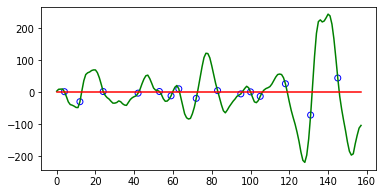

In [10]:
"""
calculate Vx and Vy zero-crossings
"""
def cal_vx_vy_zero_crossings(df):
    crossx_points_x = [] # velocity x zero-crossing points
    crossx_points_y = [] 
    crossy_points_x = [] # velocity y zero-crossing points
    crossy_points_y = []
    cross_ax_points_x = [] # Acceleration x zero-crossing points
    cross_ax_points_y = []
    cross_ay_points_x = [] # Acceleration y zero-crossing points
    cross_ay_points_y = []        
    X = df['X']
    Y = df['Y']
    d_X = df['d_X']
    d_Y = df['d_Y']
    d2_X = derivation(d_X.tolist())
    d2_Y = derivation(d_Y.tolist())
    total_num_crossx = 0 
    total_num_crossy = 0
    total_num_cross_ax = 0
    total_num_cross_ay = 0
    
    i=0
    while i< len(df)-1:
        j = i + 1
        x1 = X[i]
        y1 = Y[i]
        d_x1 = d_X[i]
        d_y1 = d_Y[i]
        d2_x1 = d2_X[i]
        d2_y1 = d2_Y[i]
        
        x2 = X[j]
        y2 = Y[j]
        d_x2 = d_X[j]
        d_y2 = d_Y[j]
        d2_x2 = d2_X[j]
        d2_y2 = d2_Y[j]        
        if (d_x1 > 0 and d_x2 < 0) or (d_x1 < 0 and d_x2 > 0) or d_x1 ==0:
            crossx_points_x.append(i)
            crossx_points_y.append(d_x1)
#             print(x1,y1,i,x2,y2,j)
            total_num_crossx += 1
        if (d_y1 > 0 and d_y2 < 0) or (d_y1 < 0 and d_y2 > 0) or d_y1 == 0:
            crossy_points_x.append(x1)
            crossy_points_y.append(y1)
            total_num_crossy += 1   
    
        if (d2_x1 > 0 and d2_x2 < 0) or (d2_x1 < 0 and d2_x2 > 0) or d2_x1 == 0:
            cross_ax_points_x.append(i)
            cross_ax_points_y.append(d2_x1)
            total_num_cross_ax += 1
        if (d2_y1 > 0 and d2_y2 < 0) or (d2_y1 < 0 and d2_y2 > 0) or d2_y1 == 0:
            cross_ay_points_x.append(x1)
            cross_ay_points_y.append(y1)
            total_num_cross_ay += 1      
        i += 1
    
#     fig = plt.figure(figsize=[6,4])
#     plt.scatter(x = df["X"], y = df["Y"], marker='o',c='', edgecolors='r')
#     plt.plot( crossx_points_x, crossx_points_y,'gx')
#     fig.show()

#     fig = plt.figure(figsize=[6,3])
#     plt.plot( range(0,len(df), 1),d_X ,'g')
#     plt.plot( [0,len(X)-1],[0,0] ,'r')
#     plt.scatter(x =crossx_points_x , y =crossx_points_y, marker='o',c='', edgecolors='b')
#     fig.show()  

#     fig = plt.figure(figsize=[6,4])
#     plt.scatter(x = df["X"], y = df["Y"], marker='o',c='', edgecolors='r')
#     plt.plot( crossy_points_x, crossy_points_y,'gx')
#     fig.show()

    fig = plt.figure(figsize=[6,3])
    plt.plot( range(0,len(df), 1),d2_X ,'g')
    plt.plot( [0,len(X)-1],[0,0] ,'r')
    plt.scatter(x =cross_ax_points_x , y =cross_ax_points_y, marker='o',c='', edgecolors='b')
    fig.show() 
    
    return total_num_crossx, total_num_crossy, total_num_cross_ax, total_num_cross_ay


temp = 'dataset/SUSIG/GENUINE/SESSION1/001_1_1.sig'    
df = pd.read_csv(temp,delimiter=' ', names=['X','Y','TStamp','Pres','EndPts'], header=None, skiprows=2)
df = preprocess(df)
df.head()
total_num_crossx, total_num_crossy, total_num_cross_ax, total_num_cross_ay = cal_vx_vy_zero_crossings(df)
print("total_num_crossx:",total_num_crossx,"total_num_crossy:",total_num_crossy)
print("total_num_cross_ax:",total_num_cross_ax,"total_num_cross_ay:",total_num_cross_ay)

9334 20653
total_num_x: 4
total_num_y: 5


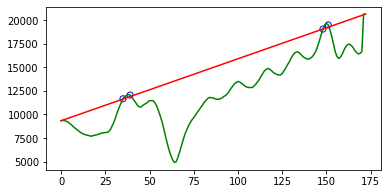

In [11]:
"""
Number of X-axis, Y-axis intersections:
"""
def cal_x_y_axis_intersections(df):
    total_num_x = 0
    cross_points_x = []
    cross_points_y = []
    X = df['X']
    start_point_x = X[0]
    end_point_x = X[len(X)-1]
    
    line_x_axis_i =start_point_x 
    block = (1.0 * (end_point_x - start_point_x)) / (len(X) -1)
    i =0
    while (i< len(X)-1):
        j = i+1
        curve_x_axis_i = X[i]
        curve_x_axis_j = X[j]
        line_x_axis_i += block
        line_x_axis_j  = line_x_axis_i + block
        if (curve_x_axis_i > line_x_axis_i and curve_x_axis_j < line_x_axis_j) or (curve_x_axis_i < line_x_axis_i and curve_x_axis_j > line_x_axis_j) or (curve_x_axis_i == line_x_axis_i):
            cross_points_x.append(i)
            cross_points_y.append(curve_x_axis_i)
            total_num_x += 1 
        i += 1
    
    print(start_point_x, end_point_x)
    fig = plt.figure(figsize=[6,3])
    plt.plot( range(0,len(df), 1),df["X"] ,'g')
    plt.plot( [0,len(X)-1],[start_point_x,end_point_x] ,'r')
    plt.scatter(x = cross_points_x, y = cross_points_y, marker='o',c='', edgecolors='b')
    fig.show()    


    total_num_y = 0
    cross_points_x = []
    cross_points_y = []
    Y = df['Y']
    start_point_y = Y[0]
    end_point_y = Y[len(Y)-1]
    
    line_y_axis_i =start_point_y 
    block = (1.0 * (end_point_y - start_point_y)) / (len(Y) -1)
    i =0
    while (i< len(Y)-2):
        j = i+1
        curve_y_axis_i = Y[i]
        curve_y_axis_j = Y[j]
        line_y_axis_i += block
        line_y_axis_j  = line_y_axis_i + block
        if (curve_y_axis_i > line_y_axis_i and curve_y_axis_j < line_y_axis_j) or (curve_y_axis_i < line_y_axis_i and curve_y_axis_j > line_x_axis_j) or (curve_y_axis_i == line_y_axis_i):
            cross_points_x.append(i)
            cross_points_y.append(curve_y_axis_i)
            total_num_y += 1 
        i += 1
        
    return total_num_x, total_num_y




temp = 'dataset/SUSIG/GENUINE/SESSION1/002_1_1.sig'    
df = pd.read_csv(temp,delimiter=' ', names=['X','Y','TStamp','Pres','EndPts'], header=None, skiprows=2)
df = preprocess(df)
df.head()
total_num_x, total_num_y = cal_x_y_axis_intersections(df)
print("total_num_x:", total_num_x)
print("total_num_y:", total_num_y)

8


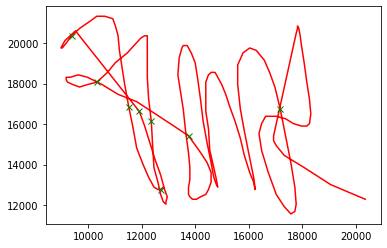

In [12]:
# 叉积判定
# Cross product judgement
def cross(p1,p2,p3): 
    x1=p2[0]-p1[0]
    y1=p2[1]-p1[1]
    x2=p3[0]-p1[0]
    y2=p3[1]-p1[1]
    return x1*y2-x2*y1     


#判断两线段是否相交 judge whether the two line segments intersect
def segment(p1,p2,p3,p4): 
    if(max(p1[0],p2[0])>=min(p3[0],p4[0])
    and max(p3[0],p4[0])>=min(p1[0],p2[0]) 
    and max(p1[1],p2[1])>=min(p3[1],p4[1]) 
    and max(p3[1],p4[1])>=min(p1[1],p2[1])): 
        if(cross(p1,p2,p3)* cross(p1,p2,p4)<=0  
        and cross(p3,p4,p1)* cross(p3,p4,p2)<=0):
            D=1
        else:
            D=0
    else:
        D=0
    return D

"""
    计算手写图形的交点的数目
    Count the number of intersections of handwritten graphics
"""
def cal_intersection_num(df):
    inter_points = []
    inter_points_x = []
    inter_points_y = []
    X = df['X']
    Y = df['Y']
    Angle = df['Angle']
    
    i=1
    while i< len(df)-8:
        j = i + 4
        x1 = X[i]
        y1 = Y[i]
        while j < len(df)-1:
            x2 = X[j]
            y2 = Y[j]
            if math.sqrt( np.square(x2-x1) + np.square(y2-y1) ) < 500 :
                p1 = (X[i-1], Y[i-1])
                p2 = (X[i+1], Y[i+1])
                p3 = (X[j-1], Y[j-1])
                p4 = (X[j+1], Y[j+1])
                # 判断两线段是否相交 Determine whether two line segments intersect
                if segment(p1,p2,p3,p4) == 1:
                    inter_points_x.append(x1)
                    inter_points_y.append(y1)
#                     print(x1,y1,i,Angle[i],x2,y2,j,Angle[j])
                    i += 3
                    break
            j += 1
        i += 1    
    return inter_points_x, inter_points_y
    
temp = 'dataset/SUSIG/GENUINE/SESSION1/025_1_1.sig'    
df = pd.read_csv(temp,delimiter=' ', names=['X','Y','TStamp','Pres','EndPts'], header=None, skiprows=2)
# startTime = df['TStamp'][0]
# df['TStamp2'] = (df['TStamp'] - startTime) #ms
df = preprocess(df)
df.head()
inter_points_x, inter_points_y = cal_intersection_num(df)

fig = plt.figure(figsize=[6,4])
# plt.scatter(x = df["X"], y = df["Y"], marker='o',c='', edgecolors='r')
plt.plot( df["X"],df["Y"] ,'r')
plt.plot( inter_points_x, inter_points_y,'gx')
fig.show()
print(len(inter_points_x))

In [88]:
# read dataset

base_path_forg = 'dataset/SUSIG/FORGERY' #FROM FILE PATH
base_path_genu = 'dataset/SUSIG/GENUINE/SESSION1' #FROM FILE PATH
save_base_path_forg = 'dataset/SUSIG/FEATURE/FORGERY' #SAVE FILE PATH
save_base_path_genu = 'dataset/SUSIG/FEATURE/GENUINE/SESSION1' #SAVE FILE PATH
accuracy_path = 'output/complexity/susig.txt'

DEBUG_MODE = True
TOTAL_NUM = 0.0
TOTAL_GENU = 0.0
TOTAL_FORG = 0.0
TOTAL_FN = 0.0
TOTAL_FP = 0.0
TOTAL_ACCU = 0.0
TRAINING_SET_SIZE = 3
TOTAL_FEATURE_NUM = 12
counter = 1
valid_counter = 1

regexp = r'accuracy: ([0-9\.]+)%'
accu_data = load_accuracy(accuracy_path,regexp)
regexp = r'^FRR: ([0-9\.]+)%'
FRR_data = load_accuracy(accuracy_path,regexp)
regexp = r' FAR: ([0-9\.]+)%'
FAR_data = load_accuracy(accuracy_path,regexp)

print(len(FRR_data))

df_global_features = pd.DataFrame(columns=['id', 'old_id', 'duration', 'point_num', 'vel_change_mean', 'angle_change_mean','logcr_change_mean', 
                                           'max_ditance_x', 'max_ditance_y', 'endpts_num', 'vel_change_mean_x', 'vel_change_mean_y',
                                           'intersection_num', 'vel_change_num',
                                           'total_num_crossx', 'total_num_crossy', 'total_num_cross_ax', 'total_num_cross_ay',
                                           'x_axis_intersections','y_axis_intersections',
                                          'FRR', 'FAR', 'accuracy'])

# while (counter<116):
while (counter<116):    
    if (counter<10):
        base1 = "00"
    elif (counter <100):
        base1 = "0"
    else:
        base1 = ""
        
    genuinefiles = []
    forgeryfiles = []
        
    #get genuine signature    
    for root, dirs, files in os.walk(base_path_genu):
        for f in files:
            if f.startswith(base1 + str(counter)):
                genuinefiles = np.append(genuinefiles,f)
                genuinefiles = list(genuinefiles)
#     print(genuinefiles)
    
    #get forgery signature    
    for root, dirs, files in os.walk(base_path_forg):
        for f in files:
            if f.startswith(base1 + str(counter)):
                forgeryfiles = np.append(forgeryfiles,f)
                forgeryfiles = list(forgeryfiles)
    if len(genuinefiles) == 0:
        counter += 1
        continue
        
                
    # feature extraction , preprocessing and save
    dfs_max_length = cal_dfs_max_length(base_path_genu, genuinefiles)
    
#     genu_train_files = random.sample(genuinefiles, 1)
    genu_train_files = [genuinefiles[0]]
    for f in genu_train_files:
        temp = str(base_path_genu+"/"+f)
        df = pd.read_csv(temp,delimiter=' ', names=['X','Y','TStamp','Pres','EndPts'], header=None, skiprows=2)        
        df = preprocess(df,dfs_max_length)
        
        duration = df['TStamp2'][len(df)-1]
        point_num = len(df)
        vel_change_mean_x = 0
        vel_change_mean_y= 0
        vel_change_mean = 0
        logcr_change_mean = 0
        max_ditance_x = df['X'].max() - df['X'].min()
        max_ditance_y = df['Y'].max() - df['Y'].min()
        angle_change_mean = 0
        endpts_num = len(df[df['EndPts'] == 1])
        
        vel_change_sum_x = 0
        vel_change_sum_y = 0
        vel_change_sum = 0
        angle_change_sum = 0
        logcr_change_sum = 0;
        for index, row in df.iterrows():
            vel_change_sum += abs(row['d_Vel'])
            angle_change_sum += abs(row['d_Angle'])
            logcr_change_sum += abs(row['d_Logcr'])
            vel_change_sum_x += abs(row['d2_X'])
            vel_change_sum_y += abs(row['d2_Y'])
        
        vel_change_mean = vel_change_sum /  (duration * 1.0)
        angle_change_mean = angle_change_sum /(duration * 1.0)
        logcr_change_mean = logcr_change_sum /(duration * 1.0)
        vel_change_mean_x = vel_change_sum_x /  (duration * 1.0)
        vel_change_mean_y = vel_change_sum_y /  (duration * 1.0)
        
        inter_points_x, inter_points_y = cal_intersection_num(df)
        intersection_num = len(inter_points_x)
        vel_change_num = cal_vel_change_num(df) 
        total_num_crossx, total_num_crossy, total_num_cross_ax, total_num_cross_ay = cal_vx_vy_zero_crossings(df)
        x_axis_intersections, y_axis_intersections = cal_x_y_axis_intersections(df)         
        
        print("valid_counter:"+ str(valid_counter), duration, point_num, vel_change_mean, 
              angle_change_mean,logcr_change_mean, max_ditance_x, max_ditance_y, endpts_num, vel_change_mean_x, vel_change_mean_y,
              "FRR:" + str(FRR_data[valid_counter-1]) + "%",
              "FAR:" + str(FAR_data[valid_counter-1]) + "%",
              "accuracy:" + str(accu_data[valid_counter-1]) + "%")
        
        df_global_features.loc[len(df_global_features)] = {'id': valid_counter, 'old_id': counter, 'duration': duration, 
                        'point_num': point_num,
                       'vel_change_mean': vel_change_mean, 'angle_change_mean': angle_change_mean,'logcr_change_mean': logcr_change_mean,
                       'max_ditance_x': max_ditance_x, 'max_ditance_y': max_ditance_y,'endpts_num': endpts_num,
                       'vel_change_mean_x': vel_change_mean_x,'vel_change_mean_y': vel_change_mean_y,'intersection_num': intersection_num,
                       'vel_change_num': vel_change_num,
                       'total_num_crossx': total_num_crossx, 'total_num_crossy':total_num_crossy, 
                       'total_num_cross_ax': total_num_cross_ax, 'total_num_cross_ay': total_num_cross_ay,
                       'x_axis_intersections': x_axis_intersections, 'y_axis_intersections': y_axis_intersections,                                                              
                       'FRR': FRR_data[valid_counter-1],
                       'FAR': FAR_data[valid_counter-1],'accuracy': accu_data[valid_counter-1]} 
        
        
#         df.to_csv(path_or_buf=save_base_path_genu+"/"+f,sep=" ",header=True, index= False)
    
#     for f in forgeryfiles:
#         temp = str(base_path_forg+"/"+f)
#         df = pd.read_csv(temp,delimiter=' ', names=['X','Y','TStamp','Pres','EndPts'], header=None, skiprows=2)        
#         df = preprocess(df,dfs_max_length)    
#         df.to_csv(path_or_buf=save_base_path_forg+"/"+f,sep=" ",header=True, index= False)

        
    
    
    
    
    # X Y TStamp Pres EndPts TStamp2 Angle Vel Logcr Tam normalX normalY d_normalX d_normalY d_Angle d_Vel d_Logcr d_Tam

#     genu_train_dfs = []
#     for f in genuinefiles:
#         temp = str(save_base_path_genu+"/"+f)
#         df = pd.read_csv(temp,delimiter=' ', names=['X','Y','TStamp','Pres','EndPts','TStamp2','Angle','Vel','Logcr','Tam','normalX','normalY', 
#                                                     'd_normalX','d_normalY','d_Angle','d_Vel','d_Logcr','d_Tam'], header=None, skiprows=1)        
        
#         genu_train_dfs.append(df)
        
#     #calculate the threshold distance from training set
#     for i in range(0, len(genu_train_dfs)-1):
#         data1 = genu_train_dfs[i]
#         for j in range(i+1, len(genu_train_dfs)):
#             data2 = genu_train_dfs[j]
#             #set ts_a
#             ts_a = get_ts(data1)
#             #set ts_b
#             ts_b =  get_ts(data2)
#             distance, path = fastdtw(ts_a, ts_b, radius=TOTAL_FEATURE_NUM, dist=euclidean)
#             print("genuine signature distance: ", distance)
            
    counter += 1
    valid_counter += 1

FAR_class = []
for index, row in df_global_features.iterrows():
    if float(row['FAR']) == 0:
        FAR_class.append(0)
    elif float(row['FAR']) <= 20.0:
        FAR_class.append(1)
    else:
        FAR_class.append(2)
df_global_features['FAR_class']= FAR_class  


df_global_features.to_csv(path_or_buf= "output/complexity.csv",sep=",",header=True, index= False)    

94


TypeError: an integer is required (got type tuple)

In [13]:
df = pd.read_csv("output/complexity.csv",delimiter=',')

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor 

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVR, SVC
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
from numpy import *
from scipy.stats import pearsonr
from sklearn.neighbors import KNeighborsClassifier





df = pd.read_csv("output/complexity.csv",delimiter=',')
df['intersection_num_by_duration'] = df['intersection_num'] / df['duration']
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]


# cols = ['accommodates','bedrooms','bathrooms','beds','minimum_nights','maximum_nights','number_of_reviews'] #选择测试集的训练的列
# knn = KNeighborsRegressor(10) #模型近邻值手动设置成10,其他为默认参数
# knn.fit(norm_train_df[cols], norm_train_df['price']) #X放入训练集数据，Y放入目标输出数据
# two_features_predictions = knn.predict(norm_test_df[cols]) #输出测试集结果

# 'FRR', 'FAR', 'accuracy']
df_train = df.copy().iloc[0:88]
# cols = ['duration', 'point_num', 'vel_change_mean', 'angle_change_mean','logcr_change_mean', 
#     'max_ditance_x', 'max_ditance_y', 'endpts_num', 'vel_change_mean_x', 'vel_change_mean_y',
#         'intersection_num_by_duration',
#         'intersection_num','vel_change_num',
#        'total_num_crossx', 'total_num_crossy', 'total_num_cross_ax', 'total_num_cross_ay',
#        'x_axis_intersections',
#        ]
cols = ['duration', 'point_num', 'vel_change_mean', 'angle_change_mean','logcr_change_mean', 
    'max_ditance_x', 'max_ditance_y', 'endpts_num', 'vel_change_mean_x', 'vel_change_mean_y',
        'intersection_num_by_duration',
        'intersection_num','vel_change_num',
       'total_num_crossx', 'total_num_crossy', 'total_num_cross_ax', 'total_num_cross_ay',
       'x_axis_intersections','y_axis_intersections',
       ]
# cols = ['duration', 'point_num', 'vel_change_mean', 'angle_change_mean','logcr_change_mean']
p_col = 'FAR_class'
X_train = df_train[cols]
y_train = df_train[p_col]
 
df_test = df.copy().iloc[88:94]
X_test = df_test[cols]
y_test = df_test[p_col]

# KNN
# neigh = KNeighborsRegressor(n_neighbors=3)
# neigh.fit(X_train, y_train)
# print(neigh.predict(X_test).tolist())
# print(y_test.tolist())

#decision tree
# clf = DecisionTreeRegressor()
# clf = clf.fit(X_train, y_train)
# print(clf.predict(X_test).tolist())
# print(y_test.tolist())

#SVM
df_X = df.copy()[cols]
df_Y = df.copy()[p_col]
# df_X = (df_X-df_X.mean())/df_X.std()
# df_X = (df_X-df_X.min())/(df_X.max()-df_X.min())
 
#stadardization
# df_X = StandardScaler().fit_transform(df_X)
#归一化，返回值为归一化后的数据
# df_X = Normalizer().fit_transform(df_X)

#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
#输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数
# df_X = SelectKBest(lambda X, Y: array(list(map(lambda x: pearsonr(x, Y)[0], X.T))).T, k=5).fit_transform(df_X, df_Y)
# print(df_X)


# print(df_Y)
# for c in cols:
#     pccs = pearsonr(df_X[c].tolist(), df_Y.tolist())
#     print(c + ": " + str(pccs))
                           
# df_Y = np.asarray(df_Y).squeeze()

# print(df.corr())

X = df.copy()[cols].values
# X = preprocessing.scale(X)  # 调用sklearn包的方法
# X = stats.zscore(X)
X = np.nan_to_num(X)
y = df.copy()[p_col].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)
svr = SVC()
print("here")
# SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
# gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
# tol=0.001, verbose=False)

tuned_parameters = [{'kernel': ['rbf','poly'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'verbose':[10],'degree':[10],},
#                     {'kernel': ['poly'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'verbose':[10]}, 
                   ]
clf = GridSearchCV(svr, tuned_parameters,cv=3)
clf.fit(X_train, Y_train)
# print (clf.get_params)
# print (clf.best_params_)
score = clf.score(X_test, Y_test)
preds = clf.predict(X_test)
print ("Correct Results")
print (Y_test.tolist())
print ("Predicted Results")
print (preds.tolist())
print ("Score:" + str(score))


here
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Correct Results
[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0]
Predicted Results
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Score:0.8275862068965517


In [15]:
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split

df_X = df.copy()[cols]
# df_X = preprocessing.scale(df_X)  
# df_X = stats.zscore(df_X)
# df_X = np.nan_to_num(df_X)
df_Y = df.copy()[p_col].values
# log_reg = LogisticRegression(multi_class='ovr', solver='sag')
# log_reg = LogisticRegression( solver = 'lbfgs', multi_class = 'auto')
log_reg = LogisticRegression( solver = 'sag', multi_class = 'auto')



# 划分训练集和测试集 sepearte the training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.3)

param_grid = {
    'tol': [1e-4, 1e-3, 1e-2],
    'C': [0.4, 0.6, 0.8]
}

grid_search = GridSearchCV(log_reg, param_grid, cv=5)
grid_search.fit(X_train, Y_train)

print(grid_search.score(X_test, Y_test))  # score
print(grid_search.best_params_)  # best parameters
print(grid_search.best_estimator_)  # best estimators
preds = grid_search.predict(X_test)
print("pred:",preds.tolist())
print("test:",Y_test.tolist())



0.7586206896551724
{'C': 0.4, 'tol': 0.0001}
LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
pred: [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
test: [2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 2]


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.3, random_state=1)

#NEURAL NET
clf = MLPClassifier(solver='lbfgs', alpha=0.001, random_state=2, hidden_layer_sizes=(256, 128, 64)).fit(X_train, Y_train)
score = clf.score(X_test, Y_test)
print(clf.score(X_test, Y_test))  # score
preds = clf.predict(X_test)
print(preds.tolist())
print(Y_test.tolist())

0.7586206896551724
[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0]
[0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [17]:
#KNN
X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.25)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)

#predict
y_predict = knn.predict(X_test)
print("actural results:", Y_test.tolist())
print("predicted results:", y_predict.tolist())
# score
print("accuracy:", knn.score(X_test, Y_test))

actural results: [0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0]
predicted results: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
accuracy: 0.75


Computing CV fold: 1/6..
78 16
Computing CV fold: 2/6..
78 16
Computing CV fold: 3/6..
78 16
Computing CV fold: 4/6..
78 16
Computing CV fold: 5/6..
79 15
Computing CV fold: 6/6..
79 15


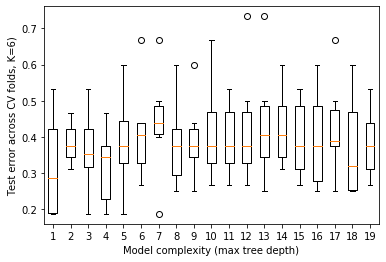

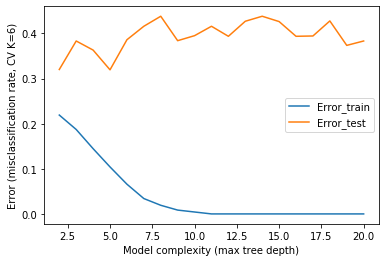

[0.32013889 0.38333333 0.36319444 0.31944444 0.38611111 0.41597222
 0.43819444 0.38402778 0.39513889 0.41597222 0.39375    0.42708333
 0.43819444 0.42638889 0.39375    0.39444444 0.42777778 0.37361111
 0.38333333]


In [19]:
# decision tree & cross validation
from matplotlib.pyplot import figure, plot, xlabel, ylabel, legend, show, boxplot
from scipy.io import loadmat
from sklearn import model_selection, tree
import numpy as np
from scipy import stats
from sklearn import preprocessing

# Load Matlab data file and extract variables of interest
# mat_data = loadmat('../Data/wine2.mat')
# X = mat_data['X']
# y = mat_data['y'].squeeze()

X = df.copy()[cols]
y = df.copy()[p_col]
X = X.values
X = preprocessing.scale(X)  
X = stats.zscore(X)
X = SelectKBest(lambda X, Y: array(list(map(lambda x: pearsonr(x, Y)[0], X.T))).T, k=5).fit_transform(X, y)

# attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
# classNames = [name[0][0] for name in mat_data['classNames']]
N, M = X.shape
# C = len(classNames)
# print (attributeNames)

# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 21, 1)

# K-fold crossvalidation
K = 6
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variable
Error_train = np.empty((len(tc),K))
Error_test = np.empty((len(tc),K))

k=0
for train_index, test_index in CV.split(X):
    print('Computing CV fold: {0}/{1}..'.format(k+1,K))

    # extract training and test set for current CV fold
    X_train, y_train = X[train_index,:], y[train_index]
    X_test, y_test = X[test_index,:], y[test_index]
    print(len(X_train), len(X_test))
    for i, t in enumerate(tc):
        # Fit decision tree classifier, Gini split criterion, different pruning levels
        dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=t)
        dtc = dtc.fit(X_train,y_train.ravel())
        y_est_test = dtc.predict(X_test)
        y_est_train = dtc.predict(X_train)
        # Evaluate misclassification rate over train/test data (in this CV fold)
        misclass_rate_test = np.sum(y_est_test != y_test) / float(len(y_est_test))
        misclass_rate_train = np.sum(y_est_train != y_train) / float(len(y_est_train))
        Error_test[i,k], Error_train[i,k] = misclass_rate_test, misclass_rate_train
    k+=1

    
f = figure()
boxplot(Error_test.T)
xlabel('Model complexity (max tree depth)')
ylabel('Test error across CV folds, K={0})'.format(K))

f = figure()
plot(tc, Error_train.mean(1))
plot(tc, Error_test.mean(1))
xlabel('Model complexity (max tree depth)')
ylabel('Error (misclassification rate, CV K={0})'.format(K))
legend(['Error_train','Error_test'])
    
show()

print(Error_test.mean(1))

x_class:0.835752064587888
misclass_rate:0.07142857142857142
test: [0 1 0 0 0 0 0 2 0 0 0 0 0 0]
predict: [0 0 0 0 0 0 0 2 0 0 0 0 0 0]

Probability of given sample being a low strength concrete: 0.8358

Overall misclassification rate: 0.071


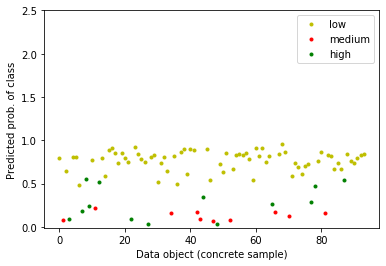

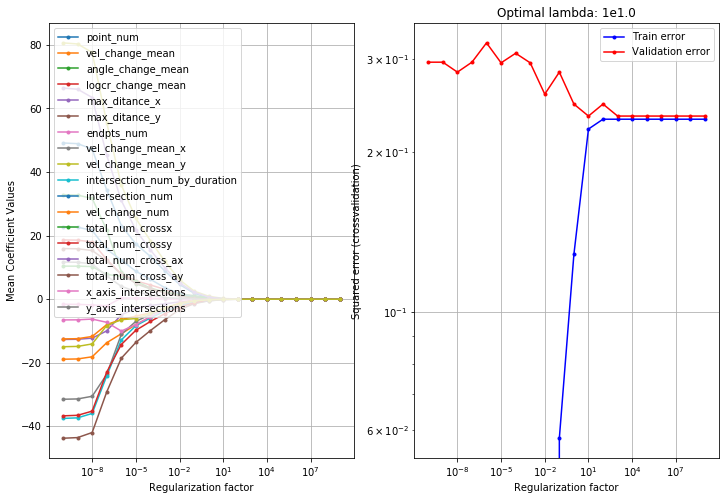

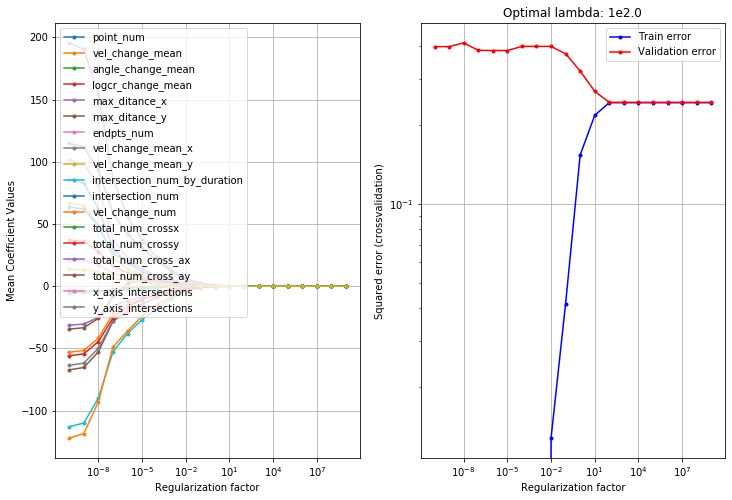

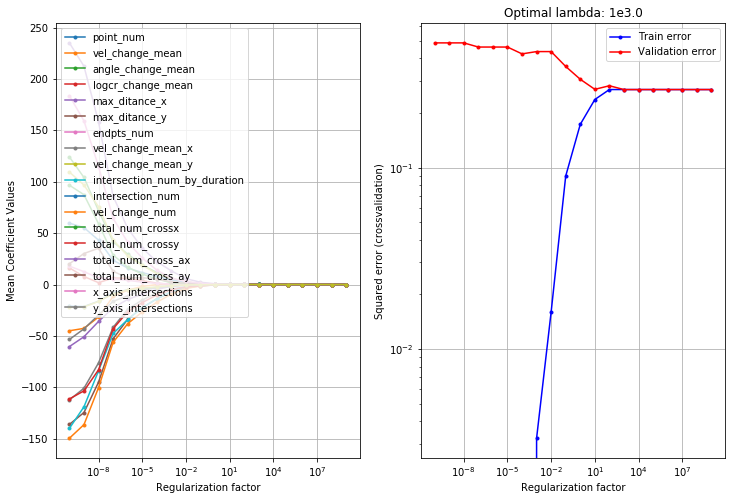

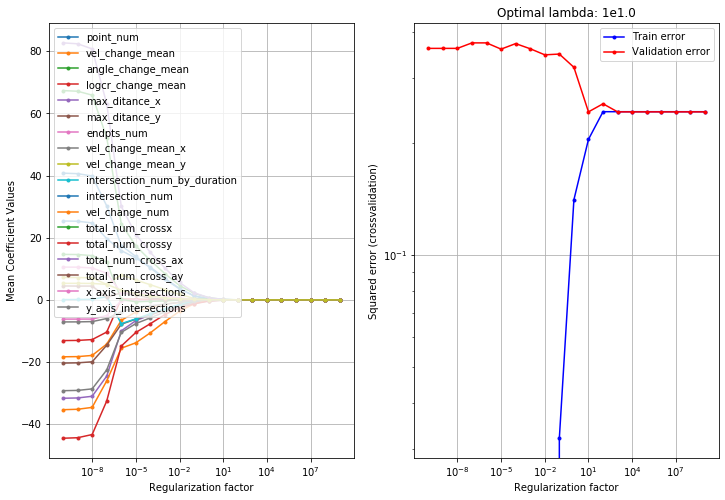

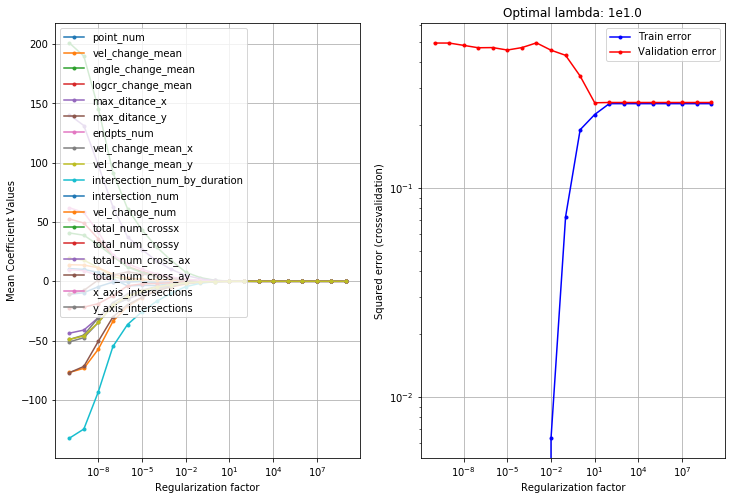

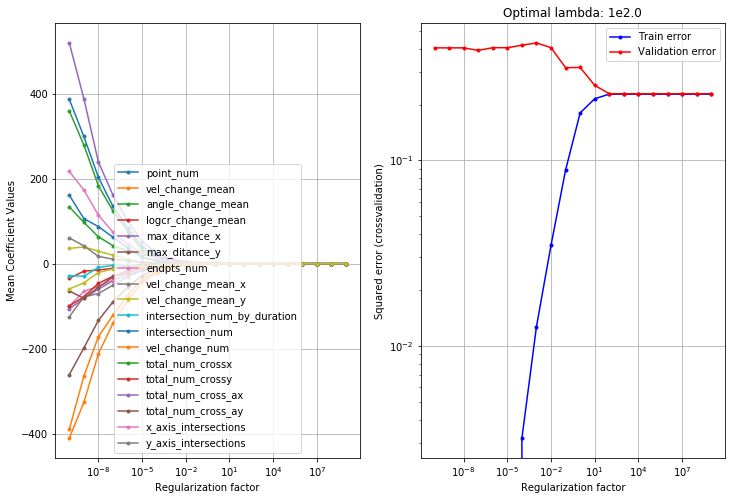

*****************************
[[  10.  100. 1000.   10.   10.  100.]]
[[0.625      0.25       0.25       0.4375     0.4        0.33333333]]
[[0.3125     0.25       0.125      0.25       0.2        0.33333333]]
Logistic regression without features:
- Training error: 1.25
- Test error:     1.25
- R^2 train:     -4.1083232010611255
- R^2 test:     -4.09915014164306

unRegularized linear regression:
- Training error: 0.22341231201990697
- Test error:     0.24513888888888888
- R^2 train:     0.08699016248480151
- R^2 test:     0.0

Regularized linear regression:
- Training error: 0.02320675105485232
- Test error:     0.3826388888888889
- R^2 train:     0.9051619321321984
- R^2 test:     -0.5609065155807367

decision tree model with depth of 15:
- Training error: 0.0
- Test error:     0.4472222222222222
- R^2 train:     1.0
- R^2 test:     -0.8243626062322946

Weights in last fold from regularized logistic model:


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [20]:
#Logistic Regression
from matplotlib.pylab import *
from scipy import stats
from sklearn import tree, model_selection
from sklearn.linear_model import LogisticRegression
from toolbox_02450 import rocplot, confmatplot
# from code.filereader import *

def reg_logistic_validate(X,y,lambdas,cvf=10):
    ''' Validate regularized logistic regression model using 'cvf'-fold cross validation.
        Find the optimal lambda (minimizing validation error) from 'lambdas' list.
        The loss function computed as mean squared error on validation set (MSE).
        Function returns: MSE averaged over 'cvf' folds, optimal value of lambda,
        average weight values for all lambdas, MSE train&validation errors for all lambdas.
        The cross validation splits are standardized based on the mean and standard
        deviation of the training set when estimating the regularization strength.
        
        Parameters:
        X       training data set
        y       vector of choice
        lambdas vector of lambda  values to be validated
        cvf     number of crossvalidation folds     
        
        Returns:
        opt_val_err         validation error for optimum lambda
        opt_lambda          value of optimal lambda
        mean_w_vs_lambda    weights as function of lambda (matrix)
        train_err_vs_lambda train error as function of lambda (vector)
        test_err_vs_lambda  test error as function of lambda (vector)
    '''
    CV = model_selection.KFold(cvf, shuffle=True)
    M = X.shape[1]
    w = np.empty((M,cvf,len(lambdas)))
    train_error = np.empty((cvf,len(lambdas)))
    test_error = np.empty((cvf,len(lambdas)))
    y = y.squeeze()
    k = 0
    for train_index, test_index in CV.split(X,y):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
        # Standardize the training and set set based on training set moments
        mu = np.mean(X_train, 0)
        sigma = np.std(X_train, 0)
        
        X_train = (X_train - mu) / sigma
        X_test = (X_test - mu) / sigma
        
        for l in range(0, len(lambdas)):
            mdl = LogisticRegression(penalty='l2', C=1/lambdas[l], solver = 'lbfgs', multi_class = 'auto')
            
            mdl.fit(X_train, y_train)
        
            y_train_est = mdl.predict(X_train).T
            y_test_est = mdl.predict(X_test).T
            
            train_error[k,l] = np.sum(y_train_est != y_train) / len(y_train)
            test_error[k,l] = np.sum(y_test_est != y_test) / len(y_test)
            w[:,k,l] = mdl.coef_[0] 
            
            #coefficient_norm[k] = np.sqrt(np.sum(w_est**2))
        k = k + 1

    opt_val_err = np.min(np.mean(test_error,axis=0))
    opt_lambda = lambdas[np.argmin(np.mean(test_error,axis=0))]
    train_err_vs_lambda = np.mean(train_error,axis=0)
    test_err_vs_lambda = np.mean(test_error,axis=0)
    mean_w_vs_lambda = np.squeeze(np.mean(w,axis=1))
    
    return opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda


# dataset
X = df.copy()[cols]
X = X.values
# X = preprocessing.scale(X)  # 
# X = stats.zscore(X)
# X = SelectKBest(lambda X, Y: array(list(map(lambda x: pearsonr(x, Y)[0], X.T))).T, k=6).fit_transform(X, y)
y = df.copy()[p_col].values
# y = y.tolist()
y_c = y

X_test = X[80:94]
y_test = y_c[80:94]
X = X[0:94]
y_c = y_c[0:94]

# X_, X_test, y_c, y_test = train_test_split(X, y_c, test_size=0.3,random_state=1)

y= y_c


N, M = X.shape
classNames = ['Low','Medium','High']
C = len(classNames)
attributeNames = cols


# Fit logistic regression model
model = LogisticRegression( solver = 'lbfgs', multi_class = 'auto')
model = model.fit(X,y_c)

# import decisiontree


# Classify concrete as Low/Medium/High (0/1/2) and assess probabilities
y_est = model.predict(X_test)
y_est_low_prob = model.predict_proba(X)[:, 0] 
y_est_medium_prob = model.predict_proba(X)[:, 1] 
y_est_high_prob = model.predict_proba(X)[:, 2] 
# Define a new data object (new type of concrete),
# x = np.array([540, 0, 0,162, 2.5, 1055, 676, 28]).reshape(1,-1)
x= X_test[2].reshape(1,-1)
# Evaluate the probability of x being a low strength (class=0) 
x_class = model.predict_proba(x)[0,0]
print("x_class:" + str(x_class))

# Evaluate classifier's misclassification rate over entire training data
misclass_rate = np.sum(y_est != y_test) / float(len(y_est))
print("misclass_rate:" + str(misclass_rate))
print("test:", y_test)
print("predict:", y_est)

# Display classification results
print('\nProbability of given sample being a low strength concrete: {0:.4f}'.format(x_class))
print('\nOverall misclassification rate: {0:.3f}'.format(misclass_rate))

f = figure();
#low
class0_ids = np.nonzero(y_c==0)[0].tolist()
plot(class0_ids, y_est_low_prob[class0_ids], '.y')

#medium
class1_ids = np.nonzero(y_c==1)[0].tolist()
plot(class1_ids, y_est_medium_prob[class1_ids], '.r')

# high
class2_ids = np.nonzero(y_c==2)[0].tolist()
plot(class2_ids, y_est_high_prob[class2_ids], '.g')


xlabel('Data object (concrete sample)'); ylabel('Predicted prob. of class');
legend(['low', 'medium', 'high'])
ylim(-0.01,2.5)

show()

################################################################################ Regularization
# Add offset attribute
#X = np.concatenate((np.ones((X.shape[0],1)),X),1)
#attributeNames = [u'Offset']+attributeNames
#M = M+1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 6
CV = model_selection.KFold(K, shuffle=True)
#CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.,range(-10,10))

# Initialize variables
#T = len(lambdas)
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))

Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
Error_train_rlogi = np.empty((K,1))
Error_test_rlogi = np.empty((K,1))
Error_train_logi = np.empty((K,1))
Error_test_logi = np.empty((K,1))
Error_train_dtc = np.empty((K,1))
Error_test_dtc = np.empty((K,1))
w_rlogi = np.empty((3,M,K)) # w for regularization logistic validation
intercept_rlogi = np.empty((3,K)) 
mu = np.empty((K, M))
sigma = np.empty((K, M))
w_noreg = np.empty((M,K))
opt_lambda_list  = np.empty((K,1))
k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y_c[train_index]
    X_test = X[test_index]
    y_test = y_c[test_index]
    internal_cross_validation = 5    

#     print(X_train)
#     print(y_train.tolist())
#     print(lambdas)
#     print(internal_cross_validation)
#     y_train = y_train.values
#     y_test = y_test.values
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = reg_logistic_validate(X_train, 
                                                                                       y_train, lambdas, internal_cross_validation)
    opt_lambda_list[k] = opt_lambda
    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k] = np.mean(X_train, 0)
    sigma[k] = np.std(X_train, 0)
    
    X_train_r = (X_train - mu[k] ) / sigma[k] 
    X_test_r = (X_test - mu[k] ) / sigma[k]
     
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.sum(y_train != stats.mode(y_train)[0])/float(len(y_train))    
    Error_test_nofeatures[k] = np.sum(y_test != stats.mode(y_test)[0])/float(len(y_test))

    # Estimate weights for regularized logistic regression, on entire training set
    model_rlogi = LogisticRegression(penalty='l2', C=1/0.0000000001 , solver = 'lbfgs', multi_class = 'auto')
    model_rlogi.fit(X_train_r, y_train)
    w_rlogi[:,:,k] = model_rlogi.coef_
    intercept_rlogi[:,k] = model_rlogi.intercept_
    y_train_r_est = model_rlogi.predict(X_train_r).T
    y_test_r_est = model_rlogi.predict(X_test_r).T
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlogi[k] = np.sum(y_train_r_est != y_train) / len(y_train)
    Error_test_rlogi[k] = np.sum(y_test_r_est != y_test) / len(y_test)

    # Estimate weights for unregularized linear regression, on entire training set
    model_logi = LogisticRegression(penalty='l2', C=1 , solver = 'lbfgs', multi_class = 'auto')
    model_logi.fit(X_train, y_train)
    
    y_train_est = model_logi.predict(X_train).T
    y_test_est = model_logi.predict(X_test).T
    # Compute mean squared error with regularization with optimal lambda
    Error_train_logi[k] = np.sum(y_train_est != y_train) / len(y_train)
    Error_test_logi[k] = np.sum(y_test_est != y_test) / len(y_test)
    
    # Estimate a decision tree model, on entire training set
    dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=15)
    dtc = dtc.fit(X_train,y_train.ravel())
    y_est_test = dtc.predict(X_test)
    y_est_train = dtc.predict(X_train)
    # Evaluate misclassification rate over train/test data (in this CV fold)
    misclass_rate_test = np.sum(y_est_test != y_test) / float(len(y_est_test))
    misclass_rate_train = np.sum(y_est_train != y_train) / float(len(y_est_train))
    Error_test_dtc[k], Error_train_dtc[k] = misclass_rate_test, misclass_rate_train

    # Display the results for the last cross-validation fold
    
    figure(k, figsize=(12,8))
    subplot(1,2,1)
    semilogx(lambdas,mean_w_vs_lambda.T,'.-') # Don't plot the bias term
    xlabel('Regularization factor')
    ylabel('Mean Coefficient Values')
    grid()
    # You can choose to display the legend, but it's omitted for a cleaner 
    # plot, since there are many attributes
    legend(attributeNames[1:], loc='best')
    
    subplot(1,2,2)
    title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
    loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
    xlabel('Regularization factor')
    ylabel('Squared error (crossvalidation)')
    legend(['Train error','Validation error'])
    grid()
    show()
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1
print('*****************************')
print(opt_lambda_list.T)
print(Error_test_rlogi.T)

print(Error_test_nofeatures.T)


# Display results
print('Logistic regression without features:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))

print('unRegularized linear regression:')
print('- Training error: {0}'.format(Error_train_logi.mean()))
print('- Test error:     {0}'.format(Error_test_logi.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_logi.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_logi.sum())/Error_test_nofeatures.sum()))

print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlogi.mean()))
print('- Test error:     {0}'.format(Error_test_rlogi.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlogi.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlogi.sum())/Error_test_nofeatures.sum()))

print('decision tree model with depth of 15:')
print('- Training error: {0}'.format(Error_train_dtc.mean()))
print('- Test error:     {0}'.format(Error_test_dtc.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_dtc.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_dtc.sum())/Error_test_nofeatures.sum()))

print('Weights in last fold from regularized logistic model:')
for m in range(M-1):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlogi[:,m,-1],2)))

In [21]:
# Fit multinomial regression
from matplotlib.pyplot import figure, show, title
from scipy.io import loadmat
from toolbox_02450 import dbplotf, train_neural_net, visualize_decision_boundary
import numpy as np
import sklearn.linear_model as lm

# Load Matlab data file and extract variables of interest

X = df.copy()[cols].values
# X = preprocessing.scale(X)
# X = stats.zscore(X)
X = np.nan_to_num(X)
y = df.copy()[p_col].values

# X = SelectKBest(lambda X, Y: array(list(map(lambda x: pearsonr(x, Y)[0], X.T))).T, k=6).fit_transform(X, y)
# X = X - np.ones((X.shape[0],1)) * np.mean(X,0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

# mat_data = loadmat('../Data/synth1.mat')
# X = mat_data['X']
# X = X - np.ones((X.shape[0],1)) * np.mean(X,0)
# X_train = mat_data['X_train']
# X_test = mat_data['X_test']
# y = mat_data['y'].squeeze()
# y_train = mat_data['y_train'].squeeze()
# y_test = mat_data['y_test'].squeeze()

# attributeNames = [name[0] for name in mat_data['attributeNames'].squeeze()]
# classNames = [name[0][0] for name in mat_data['classNames']]

attributeNames = cols
classNames = ['0','1','2']

N, M = X.shape
C = len(classNames)
#%% Model fitting and prediction

# Multinomial logistic regression
logreg = lm.LogisticRegression(solver='lbfgs', multi_class='multinomial', tol=1e-4, random_state=1)
logreg.fit(X_train,y_train)

# To display coefficients use print(logreg.coef_). For a 4 class problem with a 
# feature space, these weights will have shape (4, 2).

# Number of miss-classifications
print('Number of miss-classifications for Multinormal regression:\n\t {0} out of {1}'.format(np.sum(logreg.predict(X_test)!=y_test),len(y_test)))
# print(logreg.predict(X_test)/ (y_test*1.0))
print(logreg.predict(X_test))
print(y_test)

# predict = lambda x: np.argmax(logreg.predict_proba(x),1)
# figure(2,figsize=(9,9))
# visualize_decision_boundary(predict, [X_train, X_test], [y_train, y_test], attributeNames, classNames)
# title('LogReg decision boundaries')

show()

Number of miss-classifications for Multinormal regression:
	 6 out of 29
[0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 2 0 2 2 0 1 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


Training model of type:

Sequential(
  (0): Linear(in_features=19, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=1, bias=True)
  (3): Sigmoid()
)


Crossvalidation fold: 1/3

	Replicate: 1/5
		Iter	Loss			Rel. loss
		1000	0.665979	4.9759125e-05
		Final loss:
		1000	0.665979	4.9759125e-05

	Replicate: 2/5
		Iter	Loss			Rel. loss
		Final loss:
		657	0.64737	9.207191e-07

	Replicate: 3/5
		Iter	Loss			Rel. loss
		1000	0.66171736	1.9816612e-06
		Final loss:
		1000	0.66171736	1.9816612e-06

	Replicate: 4/5
		Iter	Loss			Rel. loss
		1000	0.5953814	0.00012472362
		Final loss:
		1000	0.5953814	0.00012472362

	Replicate: 5/5
		Iter	Loss			Rel. loss
		Final loss:
		179	0.65948474	6.32664e-07

	Best loss: 0.5953813791275024

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8) tensor([1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 0

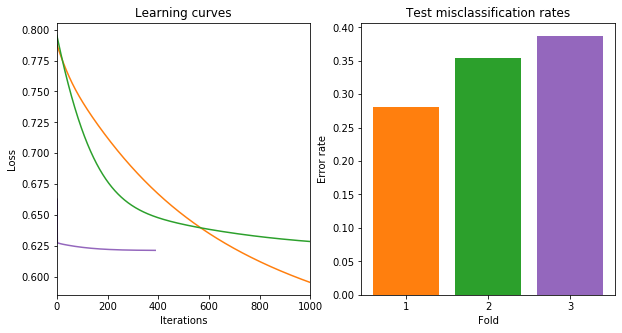

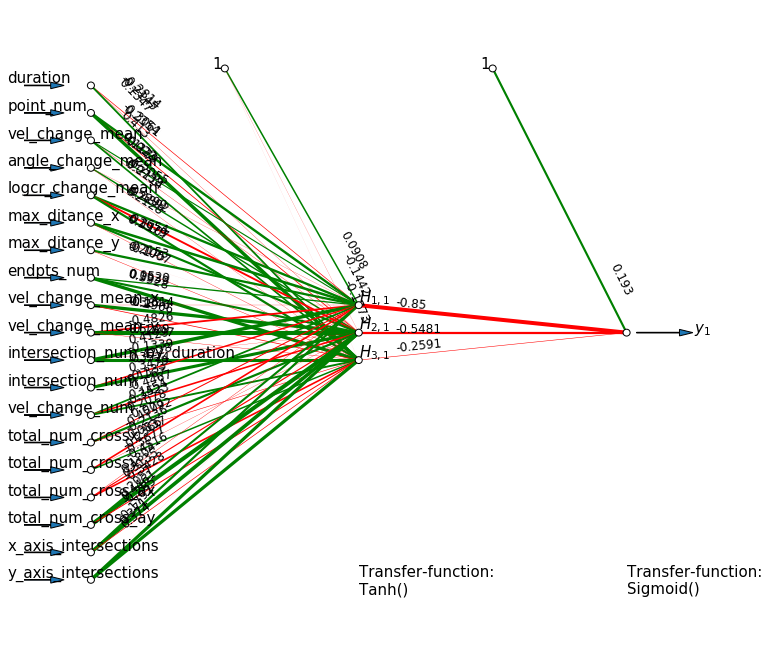


Generalization error/average error rate: 34.1062%


In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net
from scipy import stats

# Load Matlab data file and extract variables of interest
# mat_data = loadmat('../Data/wine2.mat')
# attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
# X = mat_data['X']
# y = mat_data['y']
X = df.copy()[cols].values
# X = preprocessing.scale(X)  
# X = stats.zscore(X)
X = np.nan_to_num(X)
y = df.copy()[p_col].values
# print(X)
# X = SelectKBest(lambda X, Y: array(list(map(lambda x: pearsonr(x, Y)[0], X.T))).T, k=6).fit_transform(X, y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=2)
# X = X - np.ones((X.shape[0],1)) * np.mean(X,0)
attributeNames = cols
classNames = ['0','1','2']


#Downsample: X = X[1:20,:] y = y[1:20,:]
N, M = X.shape
C = 3

# Normalize data
# X = stats.zscore(X);

# Parameters for neural network classifier
n_hidden_units = 3     # number of hidden units
n_replicates = 5        # number of networks trained in each k-fold
max_iter = 1000         # stop criterion 2 (max epochs in training)

# K-fold crossvalidation
K = 3                   # only five folds to speed up this example
CV = model_selection.KFold(K, shuffle=True)
# Make figure for holding summaries (errors and learning curves)
summaries, summaries_axes = plt.subplots(1,2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']

# Define the model
model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
loss_fn = torch.nn.BCELoss()

print('Training model of type:\n\n{}\n'.format(str(model())))
errors = [] # make a list for storing generalizaition error in each loop
for k, (train_index, test_index) in enumerate(CV.split(X,y)): 
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.tensor(X[train_index,:], dtype=torch.float)
    y_train = torch.tensor(y[train_index], dtype=torch.float)
    X_test = torch.tensor(X[test_index,:], dtype=torch.float)
    y_test = torch.tensor(y[test_index], dtype=torch.uint8)
    
    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=n_replicates,
                                                       max_iter=max_iter)
    
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_sigmoid = net(X_test)
    y_test_est = y_sigmoid>.5
    
    # Determine errors and errors
#     e = (y_test_est != y_test)
    e = y_test_est.t()[0].numpy() != y_test.numpy()
    print(y_test_est.t()[0],y_test)
    error_rate = np.sum(e)/(len(y_test)*1.0)
#     error_rate = (np.sum(e).type(torch.float)/len(y_test)).data.numpy()
    errors.append(error_rate) # store error rate for current CV fold 
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')
    
# Display the error rate across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(errors)), color=color_list)
summaries_axes[1].set_xlabel('Fold');
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('Error rate');
summaries_axes[1].set_title('Test misclassification rates')

print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,3]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print('\nGeneralization error/average error rate: {0}%'.format(round(100*np.mean(errors),4)))
